In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
import pandas as pd
import mne
import seaborn as sns
from osl_dynamics.utils import plotting
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2
import faiss
from osl_dynamics.analysis import power

from osl_dynamics import run_pipeline, inference, analysis
from osl_dynamics.analysis import spectral
from osl_dynamics.data import Data, task
from osl_dynamics.models import load

2023-06-20 13:21:53 INFO faiss.loader: Loading faiss with AVX2 support.
2023-06-20 13:21:53 INFO faiss.loader: Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2023-06-20 13:21:53 INFO faiss.loader: Loading faiss.
2023-06-20 13:21:53 INFO faiss.loader: Successfully loaded faiss.
2023-06-20 13:21:53.964000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 13:21:56.032935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /well/woolrich/projects/software/tf-2.11:/well/

In [2]:
path = os.path.join('..', 'results', 'cichy_epoched', 'cont_quantized', 'gpt2_50hz100hz', 'large')
cond = np.load(os.path.join(path, 'generate_cond.npy'))

In [17]:
# any Elekta data path will work here as all we need is the 
# magnetometer channel locations to populate the mne.info object
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = ['mag', 'grad']
raw = raw.pick(chn_type)

Opening raw data file /well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif...
    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.
Reading 0 ... 232999  =      0.000 ...   232.999 secs...


/tmp/ipykernel_2582/3477099032.py:11: RuntimeWarning: This filename (/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


In [3]:
def mulaw_inv(x, mu=255):
    '''
    Inverse mu-law companding.
    '''
    shape = x.shape

    x = x.reshape(-1)
    x = (x - 0.5) / mu * 2 - 1
    x = np.sign(x)*((1+mu)**np.abs(x)-1)/mu

    x = x.reshape(shape)
    return x

def encode(xtn):
    '''
    Encode data using mu-law companding.
    '''
    xtn = np.clip(xtn, -4, 4)

    maxabs = MaxAbsScaler()

    xtn = maxabs.fit_transform(xtn)
    return mulaw(xtn)

def mulaw(x):
    '''
    Apply mu-law companding to input data.
    '''
    mu = 255
    shape = x.shape

    x = x.reshape(-1)
    x = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)

    digitized = ((x + 1) / 2 * mu+0.5).astype(np.int32)
    x = 2 * ((digitized).astype(np.float32) / mu) - 1

    x = x.reshape(shape)
    digitized = digitized.reshape(shape)

    return digitized

In [4]:
# load data
data_dir = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', 'osl_dynamics100hz.mat')
data_dir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized',
                        'GPT2Flat_fullattention', 'gen_top0.95', 'generated_decoded.mat')
data_dir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized',
'gpt2_50hz100hz', 'random_label', 'generated.mat')

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_randomlabel_100hz')
os.makedirs(savedir, exist_ok=True)

# convert .mat to .npy
orig_data = loadmat(data_dir)['X'].T

# apply robustscaler
if 'flat' in savedir:
    data = orig_data.T
elif savedir.endswith('_100hz'):
    data = mulaw_inv(orig_data)
else:
    data = encode(orig_data)
    data = mulaw_inv(data)

data = RobustScaler().fit_transform(data)
print(data.shape)

np.save(os.path.join(savedir, 'subject01.npy'), data)

(360246, 306)


In [5]:
def power_spectra(path, info=None):
    if 'spectra' not in path:
        path = os.path.join(path, 'spectra')
    f = np.load(os.path.join(path, 'f.npy'))
    psd = np.load(os.path.join(path, 'psd.npy'))
    
    # Average over subjects and channels
    psd_mean = np.mean(psd, axis=(1))

    # Plot
    n_states = psd_mean.shape[0]
    plotting.plot_line(
        [f] * n_states,
        psd_mean,
        labels=[f"State {i}" for i in range(1, n_states + 1)],
        x_label="Frequency (Hz)",
        y_label="PSD (a.u.)",
        x_range=[f[0], f[-1]],
    )

    if info is not None:
        # p: states x channels
        p = power.variance_from_spectra(f, psd)

        # average every 3 consecutive channels
        p_grad1 = p[:, 1::3]
        p_grad2 = p[:, 2::3]
        p_grad = np.mean([p_grad1, p_grad2], axis=0)
        
        fig, axes = plt.subplots(2, p.shape[0]//2, figsize=(10, 5))
        # plot each state in a separate figure using mne.viz.plot_topomap
        for i in range(p.shape[0]):
            mne.viz.plot_topomap(p[i, ::3], info, axes=axes[i%2, i//2], show=False)

        fig, axes = plt.subplots(2, p.shape[0]//2, figsize=(10, 5))
        # plot each state in a separate figure using mne.viz.plot_topomap
        for i in range(p.shape[0]):
            mne.viz.plot_topomap(p_grad[i, :], info, axes=axes[i%2, i//2], show=False)

def covariance(base):
    data = np.load(os.path.join(base, 'subject01.npy'))

    # Compute the covariance matrix
    cov = np.cov(data, rowvar=False)
    print(cov.min(), cov.max())

    cov[np.eye(cov.shape[0], dtype=bool)] = 0

    # Plot the covariance matrix with plt with a green-red colormap
    plt.figure(figsize=(5, 5))
    plt.imshow(cov, vmin=-0.02, vmax=0.02)

def get_alpha(model_path, data_path, alp_name='gpt'):
    training_data = Data(data_path)
    training_data.prepare(n_embeddings=15, n_pca_components=80)

    # Load the trained model
    model = load(os.path.join(model_path, 'trained_model'))

    # Get the alpha parameters
    alpha = model.get_alpha(training_data)

    # Save the alpha parameters
    pickle.dump(alpha, open(os.path.join(model_path, 'inf_params', f'alp_{alp_name}.pkl'), 'wb'))


def plot(path, alp_paths=None, names=['alp']):
    # Load the training history
    history = pickle.load(open(os.path.join(path, 'trained_model', 'history.pkl'), "rb"))

    print("Free energy:", history["free_energy"])

    if alp_paths is not None:
        alps = [pickle.load(open(alp_path, 'rb')) for alp_path in alp_paths]
    else:
        alps = [pickle.load(open(os.path.join(path, 'inf_params', 'alp.pkl'), 'rb'))]
    stc_list = [inference.modes.argmax_time_courses(alp) for alp in alps]

    print(alps[0].shape)

    for alp in alps:
        plotting.plot_alpha(alp[alp.shape[0]//2:], n_samples=2000)

    ss_dict = {
        "Fractional Occupancy": [],
        "Mean Lifetime (s)": [],
        "Mean Interval (s)": [],
        "Switching Rate (Hz)": [],
        "Dataset": [],
    }
    for i, stc in enumerate(stc_list):
        fo = analysis.modes.fractional_occupancies(stc)
        lt = analysis.modes.mean_lifetimes(stc, sampling_frequency=100)
        intv = analysis.modes.mean_intervals(stc, sampling_frequency=100)
        sr = analysis.modes.switching_rates(stc, sampling_frequency=100)

        n_states = fo.shape[0]
        for state in range(n_states):
            ss_dict["Fractional Occupancy"].append(fo[state])
            ss_dict["Mean Lifetime (s)"].append(lt[state])
            ss_dict["Mean Interval (s)"].append(intv[state])
            ss_dict["Switching Rate (Hz)"].append(sr[state])
            ss_dict["Dataset"].append(names[i])
    ss_df = pd.DataFrame(ss_dict)

    # Plot
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 4))
    sns.boxplot(data=ss_df, y="Fractional Occupancy", x='Dataset', ax=ax[0], color='red')
    sns.boxplot(data=ss_df, y="Mean Lifetime (s)", x='Dataset', ax=ax[1], color='green')
    sns.boxplot(data=ss_df, y="Mean Interval (s)", x='Dataset', ax=ax[2], color='blue')
    sns.boxplot(data=ss_df, y="Switching Rate (Hz)", x='Dataset', ax=ax[3], color='purple')

    return alp, stc

def evoked_comparison(epochs_list, names=['data', 'gpt2'], chn_ids=[0]):
    values = []
    times = []
    channel = []
    trial = []
    models = []
    for epochs, name in zip(epochs_list, names):
        epochs = epochs[:, :, chn_ids]
        trials, time, chn = epochs.shape
        # create seaborn plot that shows the average evoked response for each channel
        # in epochs (trials, time, channels). use shading to show the standard deviation
        # use the following code to create the dataframe
        values.append(epochs.reshape(-1))

        # add time, channel, and trial columns
        times.append(np.tile(np.repeat(np.arange(time), chn), trials))
        channel.append(np.tile(np.arange(chn), time * trials))
        trial.append(np.repeat(np.arange(trials), time * chn))

        models.extend([name] * len(values[-1]))


    # create dataframe
    df = pd.DataFrame({
        'value': np.concatenate(values),
        'time': np.concatenate(times),
        'channel': np.concatenate(channel),
        'trial': np.concatenate(trial),
        'model': models,
    })

    # plot
    fig, ax = plt.subplots(figsize=(10, 8))

    sns.lineplot(data=df, x='time', y='value', hue='model', ax=ax, style='channel')

def evoked_analysis(base, data=True, ret_epochs=False, alp=None):

    # load event timings
    if data:
        path = os.path.join(base, 'event_times.npy')
        event_times = np.load(path)
        event_times = [(int(ev[0]/10) - 155520 - 7, ev[2]) for ev in event_times]
        event_times = [np.array(ev[0]) for ev in event_times if ev[0] > 0]
        event_times = np.array(event_times)

    else:
        path = os.path.join(base, 'generate_cond.npy')
        event_times = np.load(path)
        event_times = event_times[1:] - event_times[:-1]

        # get the indices where event_times is greater than 0
        event_times = np.where(event_times > 0)[0] - 6

    # load data
    data = np.load(os.path.join(base, 'subject01.npy'))

    # epoch data
    epochs = task.epoch(data, event_times[:-1] + 7, pre=10, post=100)

    # remove mean from each epoch by subtracting the mean of the first 10 samples
    #epochs = epochs - epochs[:, :10, :].mean(axis=1, keepdims=True)
    epochs = epochs[:, 10:, :]
    if ret_epochs:
        return epochs
    
    if alp is None:
        alp = pickle.load(open(os.path.join(base, 'inf_params', 'alp.pkl'), 'rb'))
    else:
        alp = pickle.load(open(alp, 'rb'))
    stc = inference.modes.argmax_time_courses(alp)

    event_times = event_times[event_times<stc.shape[0] - 100]

    stc_epochs = task.epoch(stc, event_times, pre=10, post=100)
    avg_stc_epoch = np.mean(stc_epochs, axis=0)

    # Calculate the baseline
    pre = 10  # number of samples before the event
    n_states = avg_stc_epoch.shape[1]
    t = (np.arange(avg_stc_epoch.shape[0]) - pre) / 100
    base_corr = np.nanmean(avg_stc_epoch[:pre], axis=0, keepdims=True)

    # Remove it from the epoched state time courses
    corr_avg_stc_epoch = avg_stc_epoch - base_corr

    # remove mean from each epoch in stc_epochs by subtracting the mean of the first 10 samples
    stc_epochs = stc_epochs - stc_epochs[:, :10, :].mean(axis=1, keepdims=True)

    # Plot the visual task
    fig, ax = plotting.plot_line([t] * n_states,
                                 corr_avg_stc_epoch.T,
                                 labels=[f"State {i}" for i in range(1, n_states + 1)],
                                 x_range=[-0.1, 1],
                                 x_label="Time (s)",
                                 y_label="Average State Activation",
    )
    ax.axvline(color="r", linestyle="--")

    return np.argmax(avg_stc_epoch, axis=-1), np.argmax(stc_epochs, axis=-1)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'data_quant', '8states')
alpha, stc = plot(savedir)
df = evoked_analysis(savedir)

In [82]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'data_quant', '8states')

In [83]:
# compute stats on generated data
data_path = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_nocondemb_100hz', 'subject01.npy')
get_alpha(model_path=savedir, data_path=data_path, alp_name='gpt_nocondemb')

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PCA components:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-16 15:58:03 INFO osl-dynamics: Explained variance: 10.9%


Preparing data:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-16 15:58:09 INFO osl-dynamics: Loading model: ../results/cichy_epoched/subj1/hmm/data_quant/8states/trained_model
2023-06-16 15:58:09 INFO osl-dynamics: Getting alpha


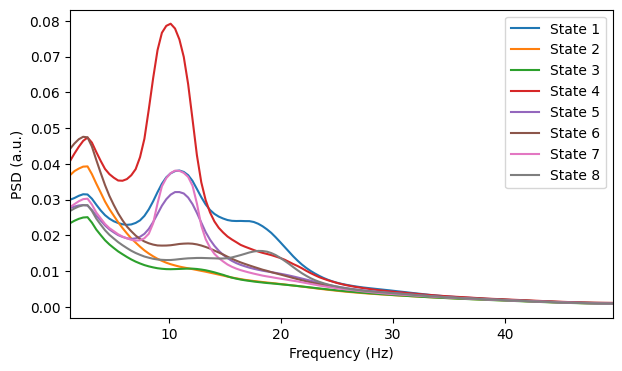

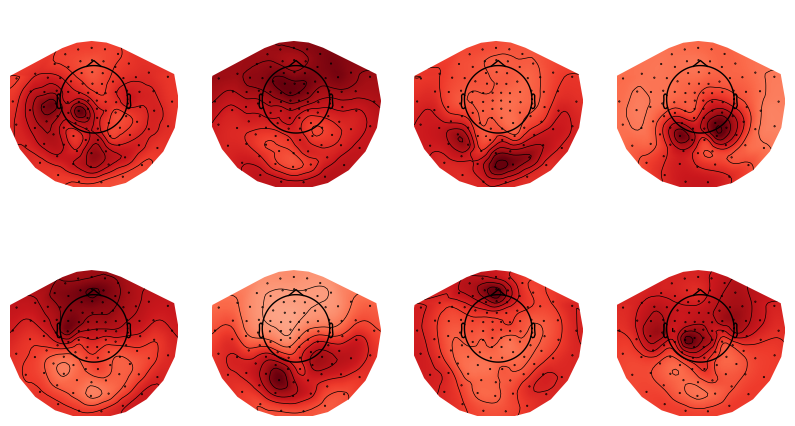

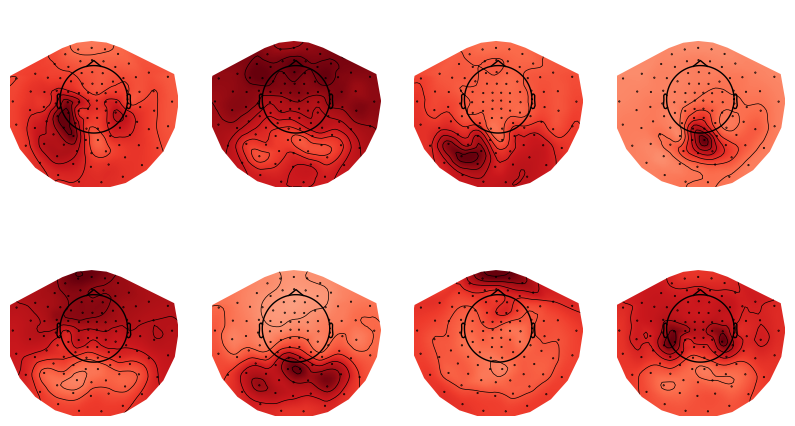

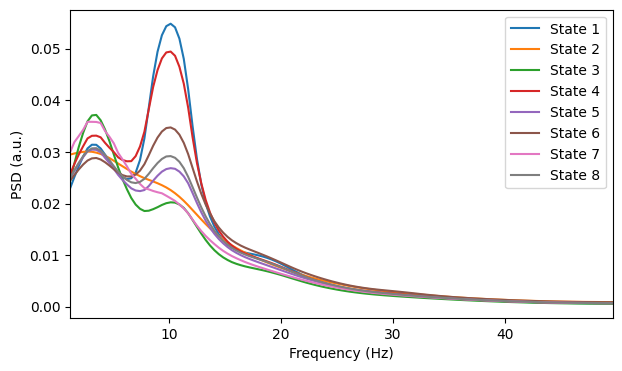

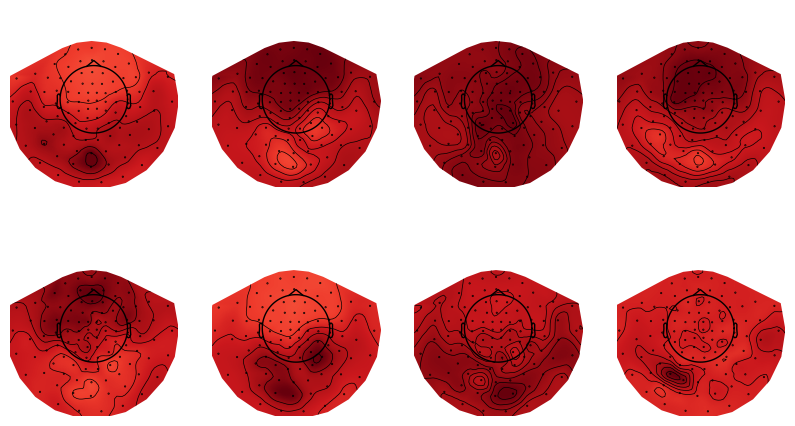

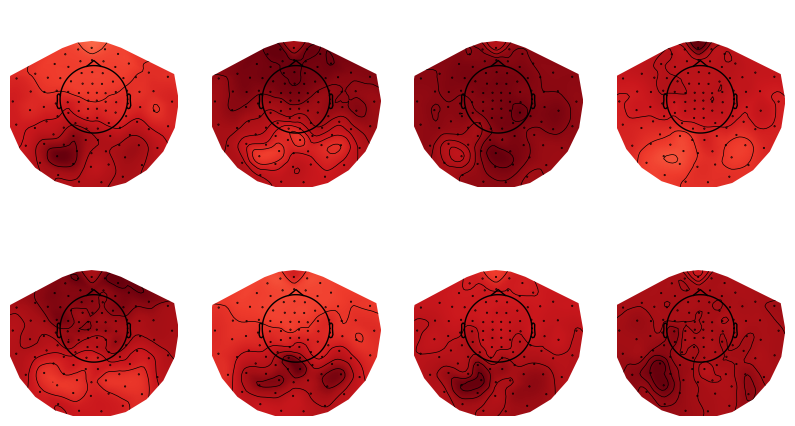

In [13]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'data_quant', '8states')
power_spectra(os.path.join(savedir, 'spectra'), raw.info)
power_spectra(os.path.join(savedir, 'spectra_gpt'), raw.info)

Free energy: 219142.70087631032
(362000, 8)


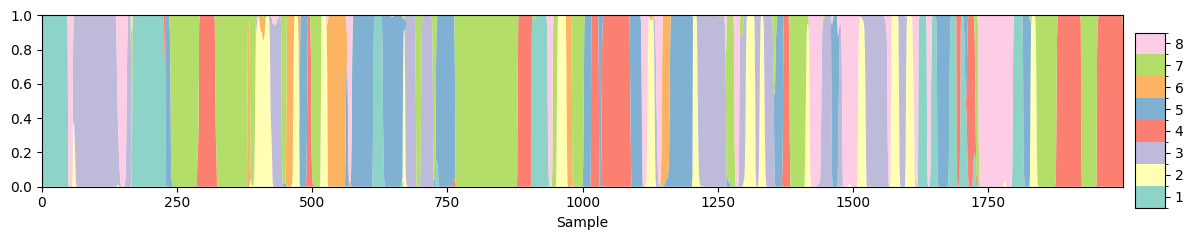

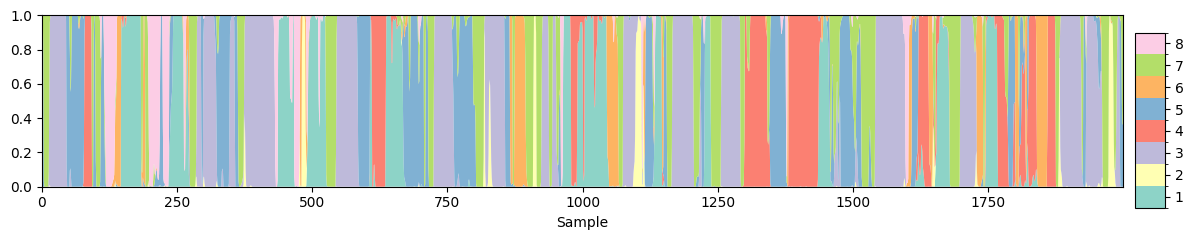

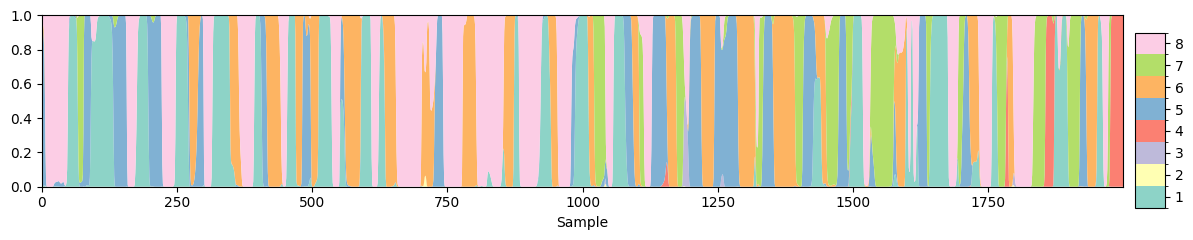

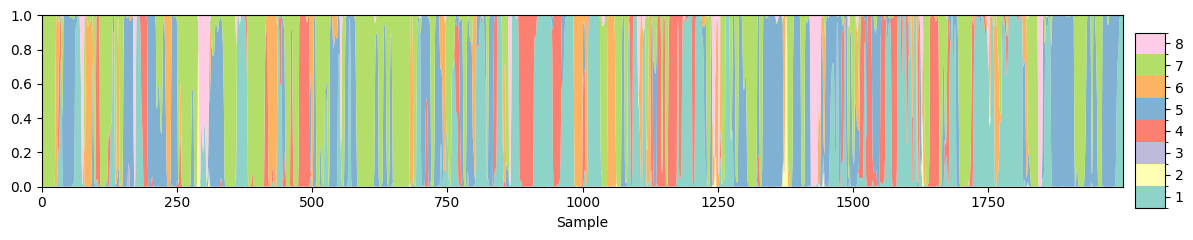

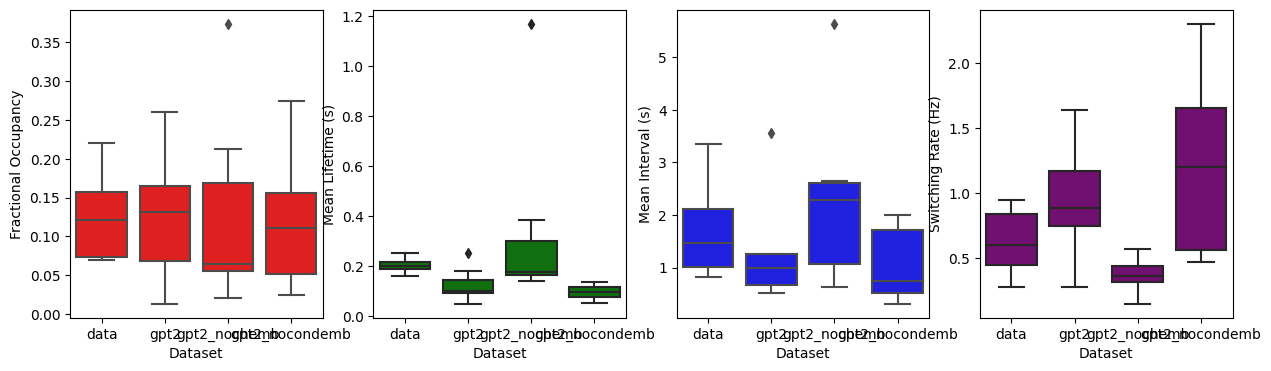

In [84]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'data_quant', '8states')
_, _ = plot(savedir, names=['data', 'gpt2', 'gpt2_nochemb', 'gpt2_nocondemb'],
            alp_paths=[os.path.join(savedir, 'inf_params', 'alp.pkl'),
                       os.path.join(savedir, 'inf_params', 'alp_gpt.pkl'),
                       os.path.join(savedir, 'inf_params', 'alp_gpt_nochemb.pkl'),
                       os.path.join(savedir, 'inf_params', 'alp_gpt_nocondemb.pkl')])

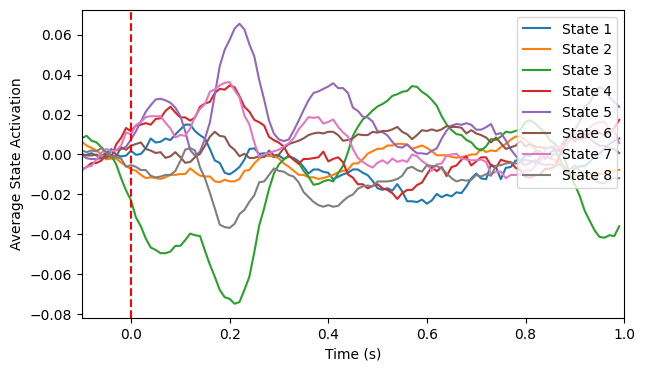

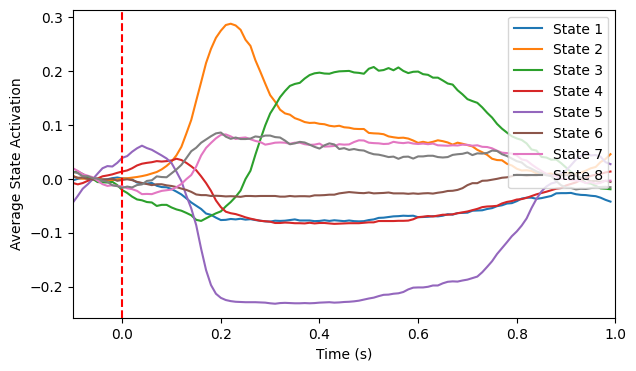

In [85]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_nochemb_100hz')
mean_stc_gpt, stc_epochs_gpt = evoked_analysis(base=savedir, data=False, alp=os.path.join(savedir, '..', 'data_quant', '8states', 'inf_params', 'alp_gpt_nochemb.pkl'))
mean_stc_data, stc_epochs_data  = evoked_analysis(os.path.join(savedir, '..', 'data_quant', '8states'))

In [ ]:
stc_epochs_data = stc_epochs_data[:300, 10:60]

In [ ]:
stc_epochs_gpt = stc_epochs_gpt[:300, 10:60]

In [ ]:
# plot the stc_epochs [trials, time] as a raster plot to show variability of timecourses
# Create a new figure and a set of subplots
fig, ax = plt.subplots(figsize=(5, 10))

# We use 'imshow' function of matplotlib for creating the raster plot
# Origin 'lower' places the [0,0] index of the array at the bottom-left corner of the axes.
# Aspect 'auto' adjusts the aspect ratio of the image to match the axes.
cax = ax.imshow(stc_epochs_data, origin='lower', aspect='auto', cmap='viridis', interpolation='nearest')

# You can add a colorbar if you want. It might be useful if the color of the cells represents some magnitude.
cbar = fig.colorbar(cax)

# Setting the labels
ax.set_xlabel("Time")
ax.set_ylabel("Trial")

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz')
covariance(savedir)
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
covariance(savedir)
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
covariance(savedir)
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2flat_fullattention')
covariance(savedir)
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2chmixsmall_100hz')
covariance(savedir)

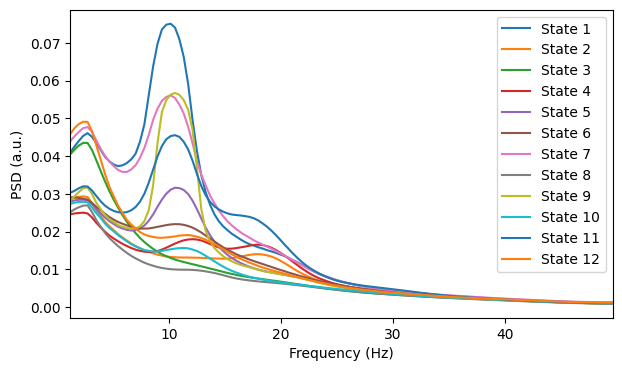

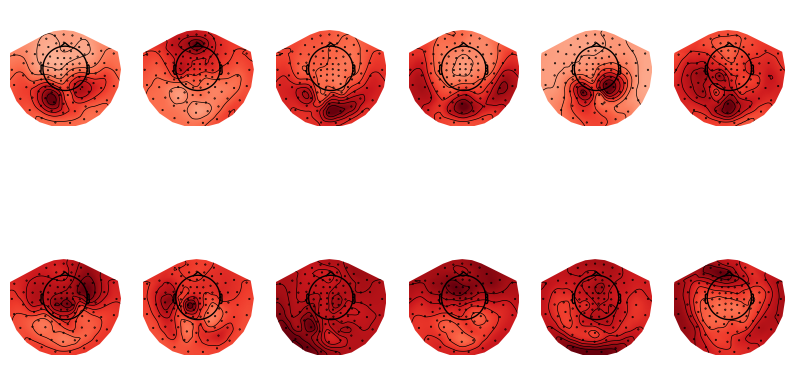

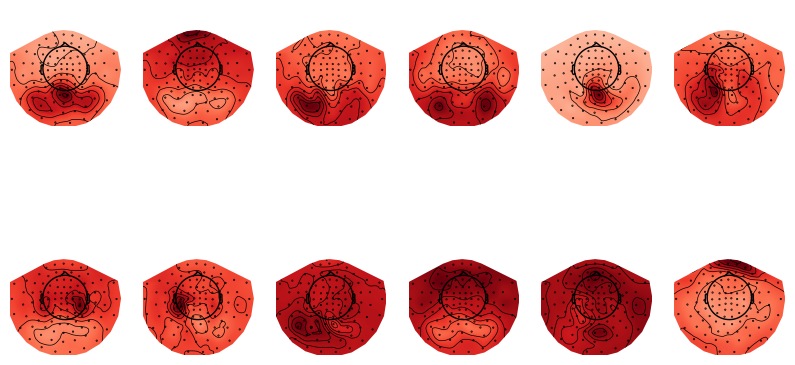

In [9]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz')
#alpha, stc = plot(savedir)
power_spectra(savedir, raw.info)
#df = evoked_analysis(savedir)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'AR255_100hz')
alpha, stc = plot(savedir)
power_spectra(savedir)
#evoked_analysis(savedir)

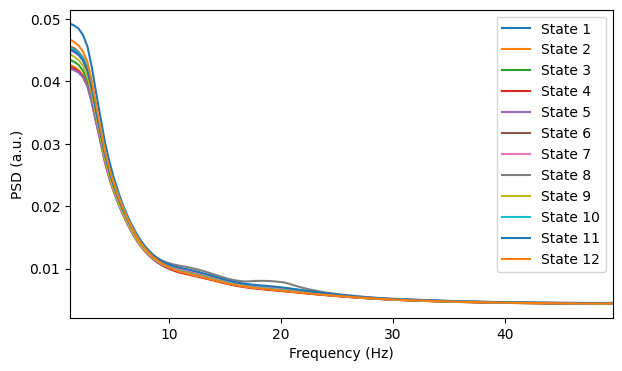

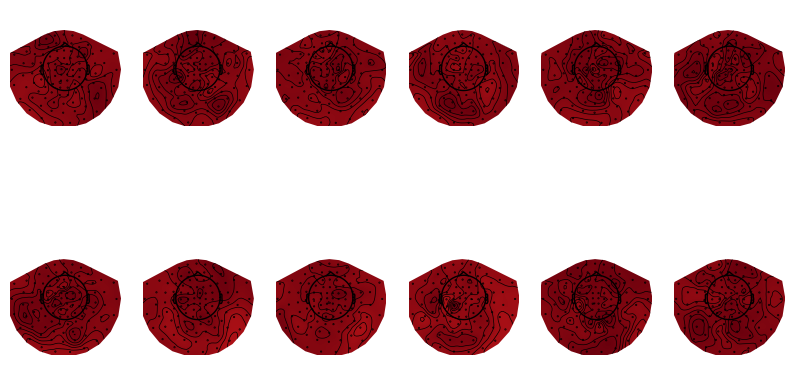

In [40]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
#alpha, stc = plot(savedir)
power_spectra(savedir, raw.info)
#evoked_analysis(savedir, data=False)

Free energy: 221295.1157959561
(360000, 12)


(array([ 8,  8,  8,  8,  5,  8,  5, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10,
         9,  9,  8,  8,  8,  8,  8,  8,  6,  6,  3,  3,  1,  3,  3,  3,  3,
         3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  0,  0,  0,  0,  9,  0,  0,  8,  9,  9,  9,  9,  8,
         9,  9, 11, 11, 11,  9,  9,  8]),
 array([[ 0,  0,  0, ...,  9,  9,  9],
        [10, 10, 10, ...,  6,  6,  6],
        [ 0,  0,  0, ...,  9,  9,  9],
        ...,
        [ 0,  0,  0, ...,  4,  4, 10],
        [ 0,  0,  0, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  4,  4,  4]]))

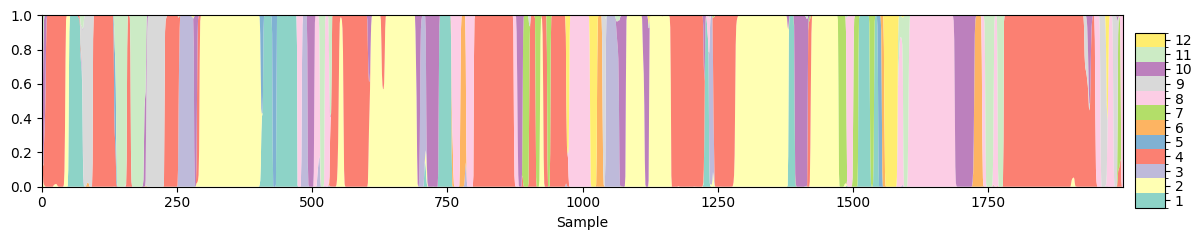

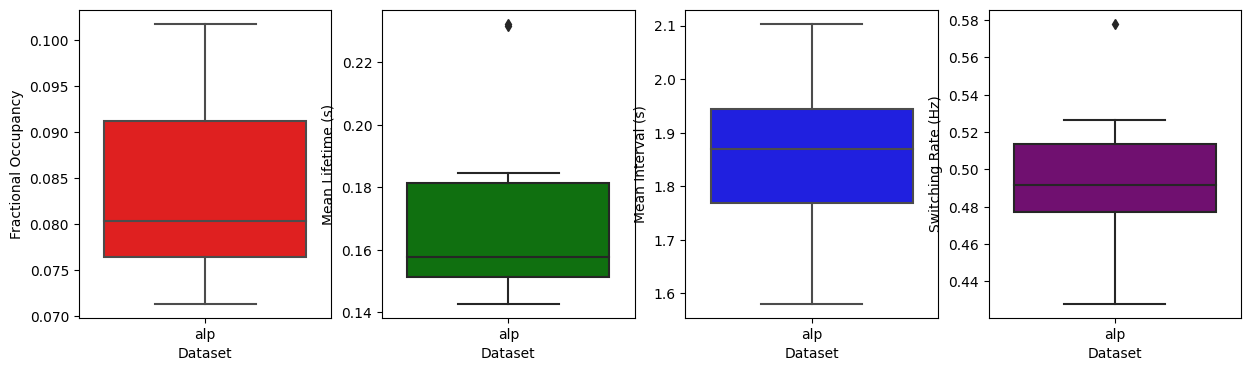

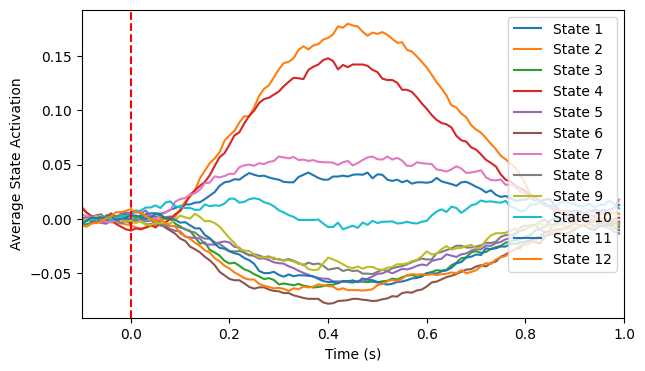

In [68]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenetfullchannel_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)
#power_spectra(savedir, raw.info)

Free energy: 172552.01866816406
(360000, 12)


(array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

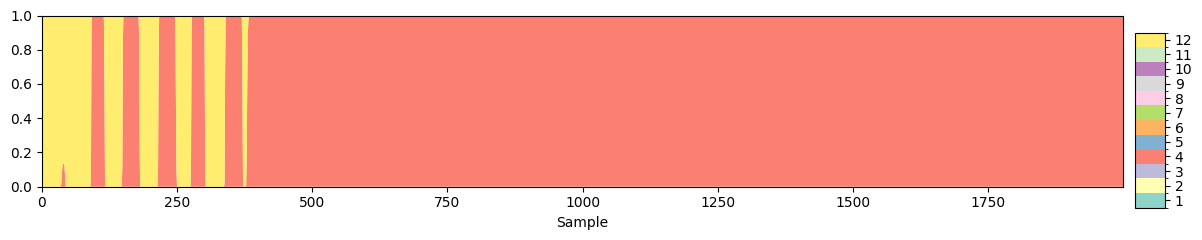

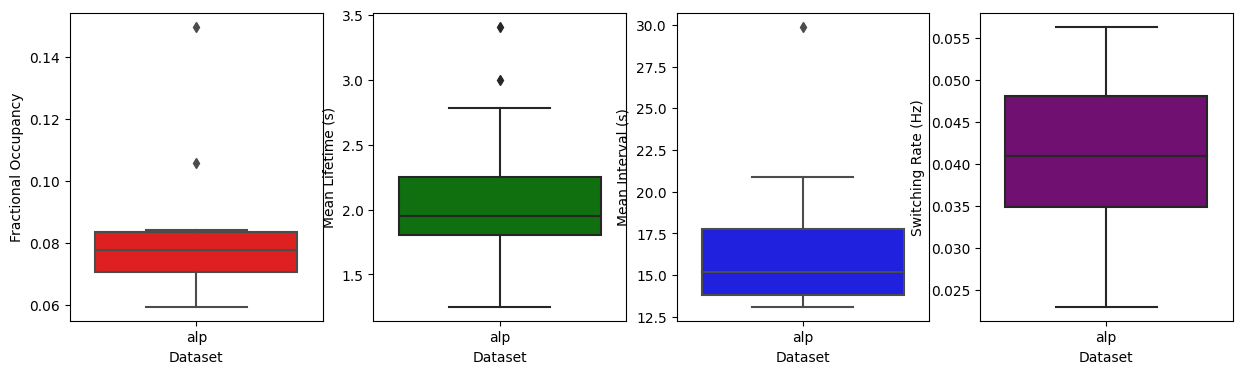

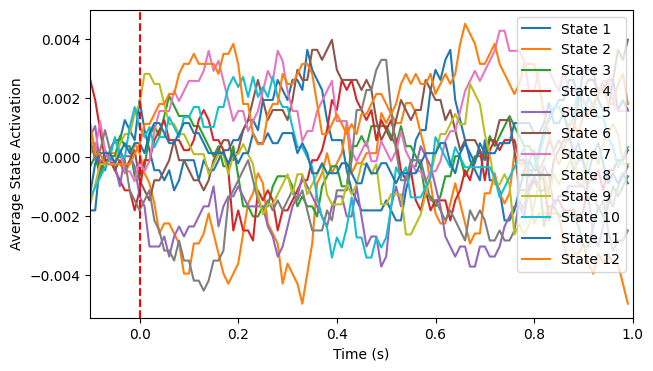

In [25]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_randomlabel_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

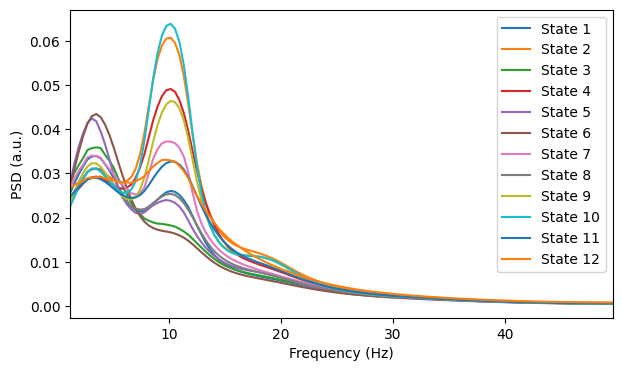

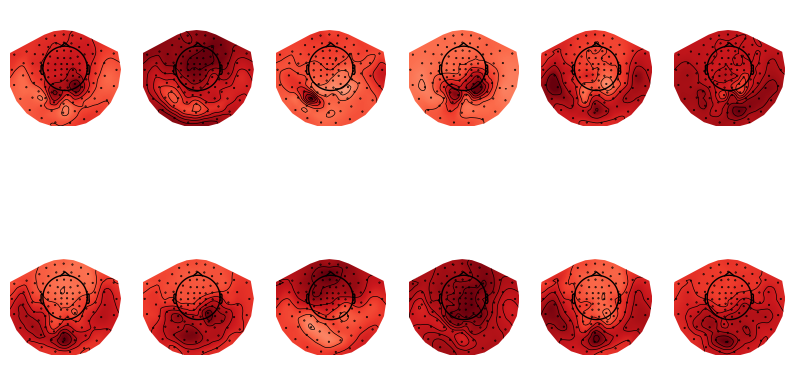

In [41]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
#alpha, stc = plot(savedir)
power_spectra(savedir, raw.info)
#evoked_analysis(savedir, data=False)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2flat_fullattention', 'p95')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_concat_output_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2chmixsmall_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_separate_heads_100hz')
alpha, stc = plot(savedir)
#evoked_analysis(savedir, data=False)

In [ ]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_random_condgen_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

In [7]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_randomlabel_100hz')
epochs_gpt_randomlabel = evoked_analysis(savedir, data=False, ret_epochs=True)

In [63]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
epochs_gpt = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_0.2condlabel_100hz')
epochs_random02 = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_0.5condlabel_100hz')
epochs_random05 = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_0.8condlabel_100hz')
epochs_random08 = evoked_analysis(savedir, data=False, ret_epochs=True)

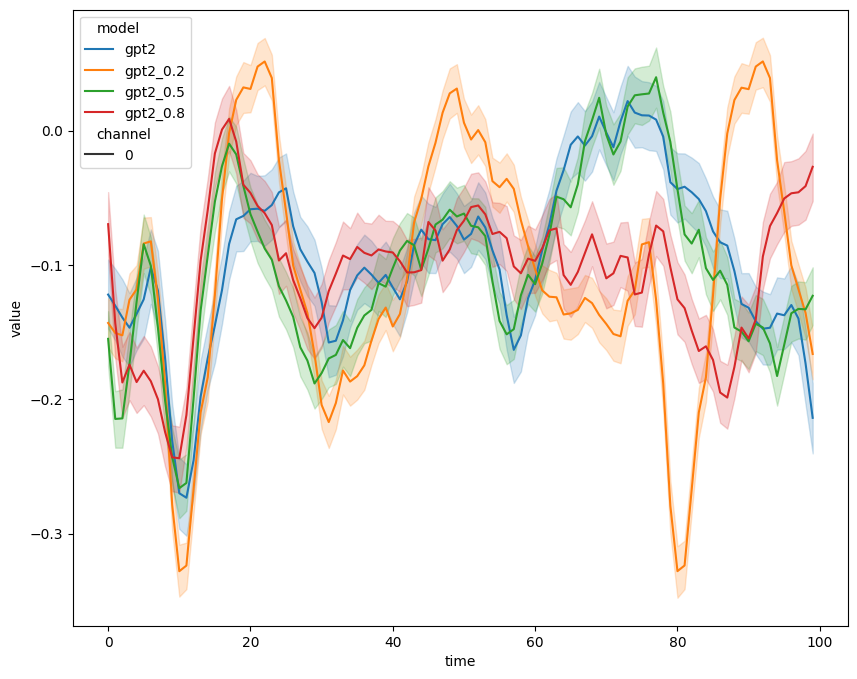

In [67]:
evoked_comparison([epochs_gpt, epochs_random02, epochs_random05, epochs_random08], chn_ids=[200], names=['gpt2', 'gpt2_0.2', 'gpt2_0.5', 'gpt2_0.8'])

In [70]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_nochemb_100hz')
epochs_nochemb = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz')
epochs_data = evoked_analysis(savedir, data=True, ret_epochs=True)

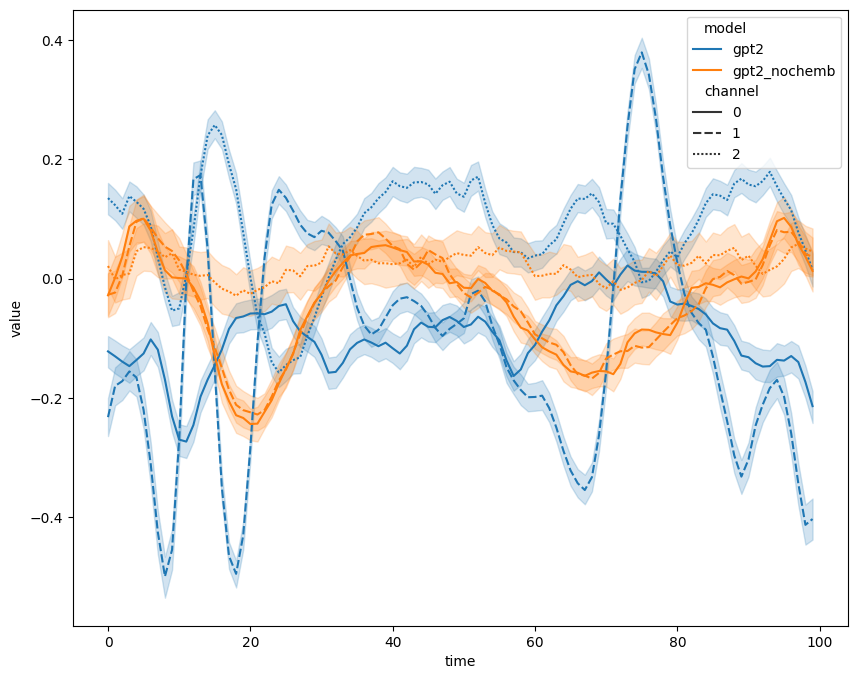

In [73]:
evoked_comparison([epochs_gpt, epochs_nochemb], chn_ids=[200, 265, 102], names=['gpt2', 'gpt2_nochemb'])

In [8]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
epochs_gpt = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2chmixsmall_100hz')
epochs_gpt_chmix = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz')
epochs_data = evoked_analysis(savedir, data=True, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_random_condgen_100hz')
epochs_gpt_random = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2flat_fullattention')
epochs_gptflat= evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
epochs_wavenet = evoked_analysis(savedir, data=False, ret_epochs=True)

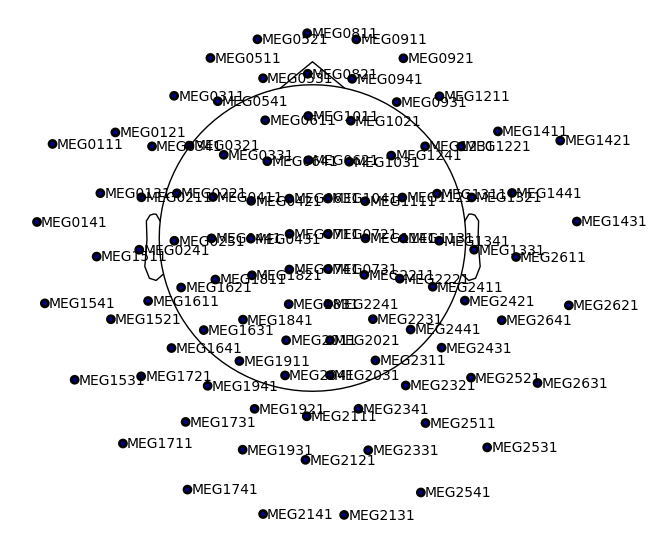

In [15]:
raw.plot_sensors(show_names=True)
e=0

In [22]:
raw.ch_names.index('MEG2521')

285

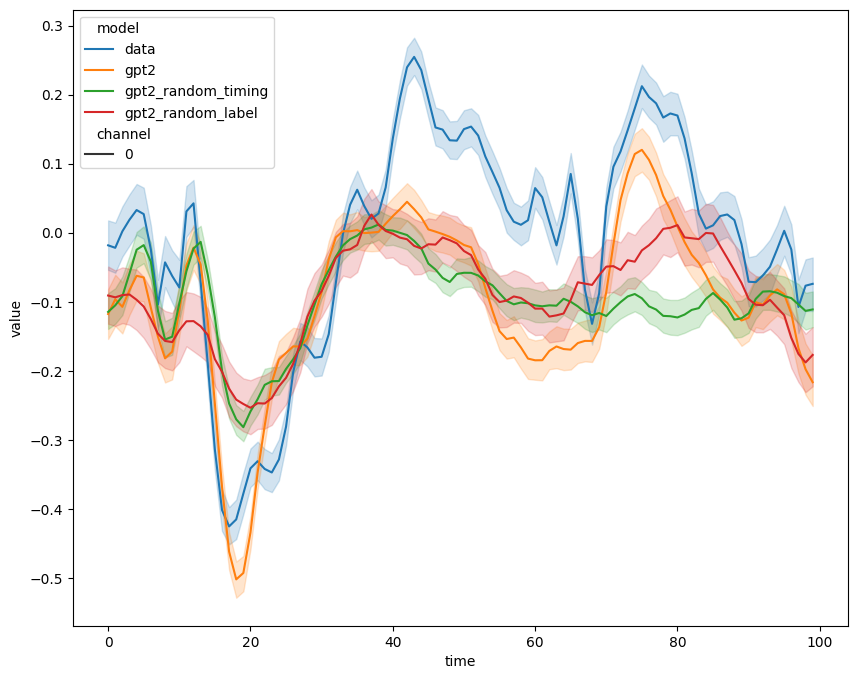

In [24]:
evoked_comparison([epochs_data, epochs_gpt, epochs_gpt_random, epochs_gpt_randomlabel], chn_ids=[286], names=['data', 'gpt2', 'gpt2_random_timing', 'gpt2_random_label'])

In [ ]:
evoked_comparison([epochs_data, epochs_gpt, epochs_gptflat, epochs_wavenet], names=['data', 'gpt2', 'gpt2flat', 'wavenet'], chn_ids=[265])

In [ ]:
plt.plot(data_var[:,3])
plt.plot(gpt_var[:,3])

In [ ]:
# mean over first dimension
data_mean = epochs_data[:, :-1, :].mean(axis=0)
gpt_mean = epochs_gpt[:, :-1, :].mean(axis=0)
gptflat_mean = epochs_gptflat[:, :-1, :].mean(axis=0)
wn_mean = epochs_wavenet[:, :-1, :].mean(axis=0)

# variance over first dimension
data_var = epochs_data[:, :-1, :].var(axis=0)
gpt_var = epochs_gpt[:, :-1, :].var(axis=0)

# create a channel x channel correlation matrix between epochs_data_mean (timesteps, channels) and epochs_gpt_mean (timesteps, channels)
cov = np.corrcoef(data_mean.T, gpt_mean.T)
cov_var = np.corrcoef(data_var.T, gpt_var.T)
cov_flat = np.corrcoef(data_mean.T, gptflat_mean.T)
cov_wn = np.corrcoef(data_mean.T, wn_mean.T)

# plot the covariance matrices
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(cov_var, cmap='RdBu_r')

# show ticks for the covariances
ax.set_xticks(np.arange(0, 2 * 306, 306))
ax.set_yticks(np.arange(0, 2 * 306, 306))

# show scale
fig.colorbar(im, ax=ax)


In [ ]:
# compute per-channel correlation between data and gpt2
corr = [np.corrcoef(data_mean[:, i], gptflat_mean[:, i])[0, 1] for i in range(data_mean.shape[1])]
print(np.array(corr).mean())

In [ ]:
# compute per-channel correlation between data and gpt2
corr = [np.corrcoef(data_var[:, i], gpt_var[:, i])[0, 1] for i in range(data_var.shape[1])]
print(np.array(corr).mean())